# Warhammer RAG

## Installation

In [1]:
!python -m pip install --upgrade pip
!pip install llama-cpp-python
!pip install cerebras-cloud-sdk
!python -m spacy download pl_core_news_lg
!pip install langchain langchain-community sentence-transformers chromadb
!pip install pypdf requests pydantic tqdm
!pip install rank_bm25
#!pip install flash-attn --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 87.5 MB/s  0:00:006m0:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp311-cp311-linux_x86_64.whl size=4422297 sha256=4a4c0ca3c5fd0b138c98710cd1e604f214ae1b0e5da9c2ab305e48ffc0eaa7bb
  Stored in directory: /root/.cache/pip/wheels/d8/5b/e5/a7d4b5765da347d314e8155197440c9995a962f8e4a5f52b23
Successfully built llama-cpp-python
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [llama-cpp-python][llama-cpp-python]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.7/573.7 MB 47.6 MB/s  0:00:076m0:00:0

## Imports

In [2]:
import os
import re
import time
import uuid
import spacy
import torch
import openai
import requests
import tiktoken
import chromadb
import numpy as np

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import LlamaCpp
from rank_bm25 import BM25Okapi
from collections import defaultdict
from chromadb.config import Settings
from kaggle_secrets import UserSecretsClient
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
from cerebras.cloud.sdk import Cerebras
from spacy.tokens import Doc
from typing import List
from tqdm import tqdm

2025-09-07 19:41:28.656309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757274088.884964      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757274088.950369      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## load secret keys

In [3]:
user_secrets = UserSecretsClient()
cerebras_key = user_secrets.get_secret("Cerebras_ai_api")
openrouter_key = user_secrets.get_secret("OPENROUTER_KEY")

## Load document

In [4]:
class Document_Loader:
    def __init__(self, 
                doc_path: str = '/kaggle/input/warhammer-4e-rpg/WFRP_4_ed_PL_1.3.pdf', 
                phrase_to_remove: str = 'Tomasz Otto (Order #44833549)',
                start_pg: int = 0, 
                end_pg: int = -1):
        self.doc_path = doc_path
        self.phrase_to_remove = phrase_to_remove
        self.start_pg = start_pg
        self.end_pg = end_pg
        self.wh_rulebook_content = None

    def load_document(self):
        loader = PyPDFLoader(self.doc_path)
        wh_rulebook = loader.load()
        wh_rulebook_content = [
                        content.page_content.replace(self.phrase_to_remove, "")
                        for content in wh_rulebook[self.start_pg:self.end_pg] # skip couple pages (title, table of contents, etc)
    ]   
        
        print("Document loaded")
        self.wh_rulebook_content = wh_rulebook_content
        return wh_rulebook_content
    
    def smart_overlap_pages(self, overlap_chars: int = 200):
        overlapped_chunks = []
        for i in range(len(self.wh_rulebook_content)):
            prev = self.wh_rulebook_content[i - 1] if i > 0 else ""
            next = self.wh_rulebook_content[i + 1] if i < len(self.wh_rulebook_content) - 1 else ""

            prev_overlap = prev[-overlap_chars:] if len(prev) > overlap_chars else prev
            next_overlap = next[:overlap_chars] if len(next) > overlap_chars else next

            chunk = prev_overlap + "\n" + self.wh_rulebook_content[i] + "\n" + next_overlap
            overlapped_chunks.append(chunk)

        print("Document chunked")
        return overlapped_chunks

## Create embedings

In [5]:
class Embeding_Creator:
    def __init__(self, model_name: str = "sdadas/mmlw-roberta-base"):
        self.model_name = model_name
        self.model = self.initialize_model()
        
    # initialize our embeddings model
    def initialize_model(self):
        # encoder - initialize our encoder to create embedings
        # sdadas/mmlw-roberta-base - 124m par
        # sdadas/mmlw-retrieval-roberta-large-v2 435m par

        model = SentenceTransformer(
            self.model_name,
            trust_remote_code=True,
            device=None,
            model_kwargs={"trust_remote_code": True}
        )
        model.bfloat16
        
        print("Embeddings model initialized")
        return model

    # create embedings for our document
    def create_embedings(self, wh_content_chunked):
        query_prefix = "zapytanie: "
        answer_prefix = ""
        wh_embedings = []

        for content in wh_content_chunked:
            queries = [query_prefix + content]
            encode = self.model.encode(queries, show_progress_bar=False)
            wh_embedings.append(encode)

        wh_embedings = torch.tensor(wh_embedings, dtype=torch.bfloat16)
        wh_embedings = wh_embedings.squeeze(1)

        print('Embedings ready')
        return wh_embedings

## Divide document by chapters

In [6]:
doc_path = '/kaggle/input/warhammer-4e-rpg/WFRP_4_ed_PL_1.3.pdf'
phrase_to_remove = 'Tomasz Otto (Order #44833549)'

loader = PyPDFLoader(doc_path)
wh_rulebook = loader.load()
wh_rulebook_content = [
                    content.page_content.replace(phrase_to_remove, "")
                    for content in wh_rulebook[6:-10] # skip table of contents and intro pages
] 

#why_rulebook_raw = ' '.join(wh_rulebook_content)

In [7]:
import re
import matplotlib.pyplot as plt

separators = []

# Sample text
for content in wh_rulebook_content:
    text = content

    # Regular expression to find words between '\n' and '\n'
    pattern = r'(?<=\n)([A-Z].{2,}[^0-9\s\n.])(?=\n)'

    # Find all matches
    matches = re.findall(pattern, text)

    # Filter sentences with 4 or fewer words
    filtered_sentences = [match for match in matches if len(match.split()) <= 4]
    separators.append(filtered_sentences)
    #print(filtered_sentences)

"""
# Create a histogram of word lengths
plt.hist(len(all_words), bins=range(1, max(len(all_words)) + 2), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths Between \\n Patterns')

# Display the plot
plt.show()
"""

"\n# Create a histogram of word lengths\nplt.hist(len(all_words), bins=range(1, max(len(all_words)) + 2), edgecolor='black', alpha=0.7)\n\n# Add labels and title\nplt.xlabel('Word Length')\nplt.ylabel('Frequency')\nplt.title('Distribution of Word Lengths Between \\n Patterns')\n\n# Display the plot\nplt.show()\n"

In [8]:
#separators = r'(?<=\n)([A-Z].*?)(?=\n)'
chunks = []
small_chunks = []

for idx, content in enumerate(wh_rulebook_content):
    if separators[idx] == []: # add whole page if no separators found
        chunks.append(content)
        continue

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        separators=separators[idx],
        is_separator_regex=False,
        keep_separator=True
    )

    texts = text_splitter.split_text(content)
    
    for text in texts:
        words = text.split()
        if len(words) < 6 and chunks:  
            chunks[-1] += " " + text
            small_chunks.append(words)
        else:
            chunks.append(text)
    '''
    for i, text in enumerate(texts):
        print(f'\nINDEX: {i} - {text}')
    break
    '''

In [85]:
import pandas as pd
words_number = [len(text.split()) for text in chunks]
words_count = pd.DataFrame(words_number, columns=['word_count'])

# count how many chunks have the same length
length_distribution = words_count['word_count'].value_counts().sort_index()

print(length_distribution)

word_count
4       2
6       8
7      20
8      24
9      17
       ..
688     1
702     1
736     1
755     1
814     1
Name: count, Length: 320, dtype: int64


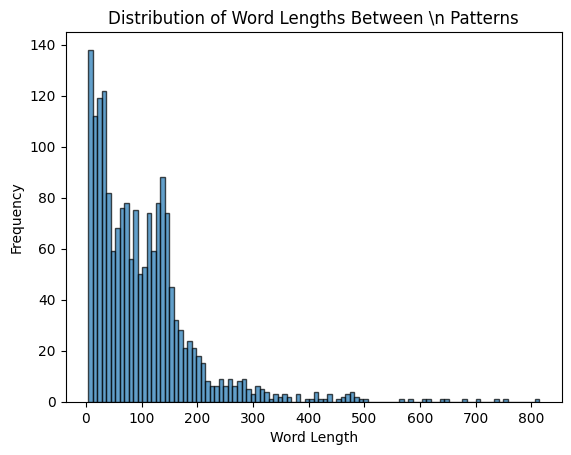

In [69]:
import matplotlib.pyplot as plt
# Create a histogram of word lengths
words_number = [len(text.split()) for text in chunks]
plt.hist(words_number, bins=100, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths Between \\n Patterns')

# Display the plot
plt.show()

In [94]:
chunks[110]

'Człowiek Krasnolud Elf Niziołek\n15+k10 15+10k10 30+10k10 15+5k10\nGENERATOR IMION ELFÓW\nJeśli podczas wymyślania imienia dla twojej elfiej postaci napotykasz trudności, rzuć kością i porównaj wynik z poniższą tabelą. \nNiektóre elfy używają wyłącznie dwóch członów w imionach, inne z kolei mogą mieć trzy lub więcej sylab. Rzucaj kośćmi, dopóki \nnie stworzysz czegoś, co ci odpowiada. Możesz też po prostu wybrać części i złożyć je w całość, która według ciebie brzmi najlepiej.\n1k10 Pierwsza sylaba Druga sylaba Końcówka (wysokie elfy) Końcówka (leśne elfy)\n1 Aes a andril arha\n2 Ath ath anel anhu\n3 Dor dia ellion dda\n4 Far en fin han\n5 Gal for il loc\n6 Im lor irian noc\n7 Lin mar mor oth\n8 Mal ol nil ryn\n9 Mor sor ric stra\n10 Ullia than wing wyth\nIIPOSTAĆ WARHAMMER FANTASY ROLEPLAY\n40'

## Vector Database

In [9]:
class VectorStore:
    def __init__(self, collection_name="warhammer fantasy", persist_directory="./chroma_db"):
        """Initialize ChromaDB vector store"""
        self.client = chromadb.PersistentClient(path=persist_directory)
        
        # Create or get collection
        self.collection = self.client.get_or_create_collection(
            name=collection_name,
            metadata={"hnsw:space": "cosine"}  # Use cosine similarity
        )
    
    def add_documents(self, chunks, embeddings):
        """Add document chunks to vector store"""
        ids = [str(uuid.uuid4()) for _ in range(len(chunks))]
        
        self.collection.add(
            documents=[chunk for chunk in chunks],
            embeddings=embeddings.tolist(),
            ids=ids
        )
    
    def similarity_search(self, query_embedding, k=5, filter_dict=None):
        """Search for similar documents"""
        results = self.collection.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=k,
            where=filter_dict
        )
        
        return results

## *Additional **optional** steps

### Hybrid retriever

Combine cos similarity method with additional one which check words frequency in our query(BM25) to choose best available chunks

In [10]:
# optional - additional retrievel to improve our performance

class HybridRetriever:
    def __init__(self, vector_store, embedding_model):
        self.vector_store = vector_store
        self.embedding_model = embedding_model
        self.bm25 = None
        self.documents = []
    
    def setup_bm25(self, documents):
        """Setup BM25 for keyword-based retrieval"""
        self.documents = documents
        tokenized_docs = [self._tokenize(doc) for doc in documents]
        self.bm25 = BM25Okapi(tokenized_docs)
    
    def _tokenize(self, text):
        """Simple tokenization for BM25"""
        return re.findall(r'\b\w+\b', text.lower())
    
    def retrieve(self, query, k=10, alpha=0.5):
        """
        Hybrid retrieval combining semantic and keyword search
        
        Args:
            query: User query
            k: Number of documents to retrieve
            alpha: Weight for semantic search (1-alpha for BM25)
        """
        # Semantic search
        query = "Zapytanie: {query}"
        query_embedding = self.embedding_model.encode(query, show_progress_bar=False)
        semantic_results = self.vector_store.similarity_search(query_embedding, k=k*2)
        
        # BM25 search
        if self.bm25:
            tokenized_query = self._tokenize(query)
            bm25_scores = self.bm25.get_scores(tokenized_query)
            bm25_results = sorted(enumerate(bm25_scores), key=lambda x: x[1], reverse=True)[:k*2]
        else:
            bm25_results = []
        
        # Combine and rerank results
        combined_results = self._combine_results(semantic_results, bm25_results, alpha)
        
        return combined_results[:k]
    
    def _combine_results(self, semantic_results, bm25_results, alpha):
        """
        Combine semantic and BM25 results with weighted scoring using document index.

        Args:
            semantic_results: List of document objects from vector store
            bm25_results: List of (index, score) tuples from BM25
            alpha: Weight for semantic scores

        Returns:
            List of combined documents reranked by hybrid score
        """
        combined_scores = defaultdict(float)

        # Normalize BM25 scores
        if bm25_results:
            bm25_values = np.array([score for _, score in bm25_results])
            bm25_norm = (bm25_values - bm25_values.min()) / (bm25_values.ptp() + 1e-9)
            for (idx, _), score in zip(bm25_results, bm25_norm):
                combined_scores[idx] += (1 - alpha) * score

        # Normalize semantic scores
        documents = semantic_results["documents"]
        semantic_values = np.array([doc.score if hasattr(doc, "score") else 1.0 for doc in documents])
        semantic_norm = (semantic_values - semantic_values.min()) / (semantic_values.ptp() + 1e-9)
        for idx, (doc, score) in enumerate(zip(documents, semantic_norm)):
            combined_scores[idx] += alpha * score

        # Rerank based on combined scores
        ranked_indices = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

        # Return document objects using indices from semantic_results["documents"]
        combined_docs = [documents[idx] for idx, _ in ranked_indices if idx < len(documents)]
        flattened_docs = [item for sublist in combined_docs for item in sublist]
        return flattened_docs

In [11]:
bm = BM25Okapi(wh_rulebook_overlap)
test = wh_rulebook_overlap[25]
bm25_scores = bm.get_scores(test)
bm25_results = sorted(enumerate(bm25_scores), key=lambda x: x[1], reverse=True)[:10*2]
bm25_results

NameError: name 'wh_rulebook_overlap' is not defined

### API tests

In [ ]:
client = Cerebras(
    # This is the default and can be omitted
    api_key=cerebras_key
)

stream = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "What is the meaning of life?"
        }
    ],
    model="llama-3.3-70b",
    stream=True,
    max_completion_tokens=10240,
    temperature=0.7,
    top_p=1
)

for chunk in stream:
  print(chunk.choices[0].delta.content or "", end="")

In [ ]:
# API Tests
# gemini - 6.5
# kimi - 5.4
# R1 - 21.8
# V3 - 12.7
# chimera - 35.6
# qwen - 29.2

models = {'r1':'deepseek/deepseek-r1-0528:free',
         'v3':'deepseek/deepseek-chat-v3-0324:free',
         'chimera':'tngtech/deepseek-r1t2-chimera:free',
         'kimi':'moonshotai/kimi-k2:free',
         'gemini':'google/gemini-2.0-flash-exp:free',
         'qwen': 'qwen/qwq-32b:free'
}

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=openrouter_key,
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  extra_body={},
  model = models['qwen'],
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)
print(completion.choices[0].message.content)

### Entities extractor

In [ ]:
# split our text into max size chunks
def chunk_text(text, chunk_size=100000):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# check for entities in our doc
nlp = spacy.load("pl_core_news_lg")  # or "md", "lg" for larger models
doc_path = '/kaggle/input/warhammer-4e-rpg/WFRP_4_ed_PL_1.3.pdf'
wh_rulebook_raw = ' '.join(load_document(doc_path))

chunks = chunk_text(wh_rulebook_raw)
docs = [nlp(chunk) for chunk in chunks]
combined_doc = Doc.from_docs(docs)
entities = [(ent.text, ent.label_) for ent in combined_doc.ents]

NameError: name 'wh_rulebook_raw' is not defined

### Query enchancer

Improve our question by generating additional querys which will help model to answer our question.  
Additionaly it check if some popular entities are not present in our query

In [11]:
class QueryEnhancer:
    def __init__(self, api_key):
        self.client = Cerebras(
        api_key=api_key
        )
    
    def expand_warhammer_query(self, query: str) -> List[str]:
        """Generate multiple query variations for better retrieval"""
        prompt = f"""
        Biorąc pod uwagę zapytanie dotyczące Warhammer Fantasy: '{query}'
        
        Wygeneruj 3 alternatywne sformułowania, które mogą pomóc w znalezieniu odpowiednich informacji:
        1. Bardziej szczegółowa wersja z terminologią Warhammer Fantasy
        2. Szersza wersja obejmująca powiązane pojęcia
        3. Wersja skupiająca się na zasadach/mechanice, jeśli ma to zastosowanie
        
        Zwróć tylko 3 zapytania, po jednym w każdym wierszu.
        """

        response = self.client.chat.completions.create(
        extra_body={},
        model = 'llama-3.3-70b',
        max_completion_tokens=10240,
        temperature=0.7,
        top_p=1,
        messages=[
            {
            "role": "user",
            "content": prompt
            }
        ]
        )
        
        variations = response.choices[0].message.content.strip().split('\n')
        clean_variations = [v.strip() for v in variations if v.strip()]
        return query + ' ' + ' '.join(clean_variations)
    
    def extract_entities(self, query: str) -> dict:
        """Extract Warhammer 40k entities from query"""
        warhammer_entities = {
            'factions': ['space marines', 'orks', 'eldar', 'tau', 'necrons', 'chaos'],
            'unit_types': ['infantry', 'vehicle', 'monster', 'character'],
            'weapons': ['bolter', 'lasgun', 'plasma', 'melta'],
            'rules': ['armor save', 'weapon skill', 'ballistic skill']
        }
        
        found_entities = {}
        query_lower = query.lower()
        
        for category, entities in warhammer_entities.items():
            found = [entity for entity in entities if entity in query_lower]
            if found:
                found_entities[category] = found
        
        return found_entities

### Context ranker

This component re-ranks retrieved documents in RAG using a cross-encoder.  
It evaluates each (query, document) pair together for relevance,  
scoring them based on semantic fit, not just keyword overlap.  
The top-ranked contexts are then passed to the language model for better answers.

In [12]:
class ContextRanker:
    def __init__(self, model_name="radlab/polish-cross-encoder"):
        """Initialize cross-encoder for reranking"""
        self.reranker = CrossEncoder(model_name, max_length=512)
    
    def rerank_contexts(self, query: str, contexts: List[str], top_k: int = 5) -> List[dict]:
        """Rerank retrieved contexts using cross-encoder"""
        # Create query-context pairs
        pairs = [(query, context) for context in contexts]
        
        # Get relevance scores
        scores = self.reranker.predict(pairs)
        
        # Sort by score and return top_k
        scored_contexts = [
            {'context': context, 'score': score}
            for context, score in zip(contexts, scores)
        ]
        
        return sorted(scored_contexts, key=lambda x: x['score'], reverse=True)[:top_k]
    
    def filter_by_relevance(self, ranked_contexts: List[dict], threshold: float = 0.3) -> List[dict]:
        """Filter contexts by relevance threshold"""
        return [ctx for ctx in ranked_contexts if ctx['score'] > threshold]

## RAG

In [13]:
class WarhammerRAG:
    def __init__(self, retriever, ranker, llm_client):
        self.retriever = retriever
        self.ranker = ranker
        self.llm_client = llm_client
    
    def generate_response(self, query: str, max_context_length: int = 9024) -> dict:
        """Generate response using RAG pipeline"""
        
        # 1. Retrieve relevant contexts
        retrieved_contexts = self.retriever.retrieve(query, k=10)
        
        # 2. Rerank contexts
        context_texts = [ctx for ctx in retrieved_contexts]
        ranked_contexts = self.ranker.rerank_contexts(query, context_texts, top_k=5)
        
        # 3. Select contexts within token limit
        selected_contexts = self._select_contexts_by_length(ranked_contexts, max_context_length)
        
        # 4. Generate response
        response = self._generate_with_context(query, selected_contexts)
        
        return {
            'response': response,
            'sources': selected_contexts,
            'retrieved_count': len(retrieved_contexts)
        }
    
    def _select_contexts_by_length(self, contexts: List[dict], max_length: int) -> List[dict]:
        """Select contexts that fit within token limit"""
        selected = []
        current_length = 0
        
        for ctx in contexts:
            ctx_length = len(ctx['context'])  # Simplified length calculation
            if current_length + ctx_length <= max_length:
                selected.append(ctx)
                current_length += ctx_length
            else:
                break
        
        return selected
    
    def _generate_with_context(self, query: str, contexts: List[dict]) -> str:
        """Generate response using LLM with retrieved context"""
        
        context_text = "\n\n".join([f"[Source {i+1}]: {ctx['context']}" 
                                   for i, ctx in enumerate(contexts)])
        
        prompt = f"""
        Jesteś asystentem eksperta ds. Warhammera fantasy. Wykorzystaj podany kontekst, aby dokładnie odpowiedzieć na pytanie użytkownika.

        Kontekst z materiałów fantastyki Warhammer: {context_text}
        Pytanie użytkownika: {query}

        Instrukcje:
        - Opieraj swoją odpowiedź przede wszystkim na podanym kontekście
        - Jeśli kontekst nie zawiera wystarczających informacji, powiedz to jasno
        - Używaj odpowiedniej terminologii Warhammer Fantasy
        - W razie potrzeby uwzględnij odpowiednie zasady, statystyki lub wiedzę
        - Podaj źródła, do których się odwołujesz (np. „Według źródła 1...”)

        Odpowiedź:
        """
        
        response = self.llm_client.chat.completions.create(
            extra_body={},
            model = 'llama-3.3-70b',
            max_completion_tokens=10240,
            temperature=0.7,
            top_p=1,
            messages=[
            {
            "role": "user",
            "content": prompt
            }
        ]
        )
        
        return response.choices[0].message.content

## Pipeline

In [14]:
# define our querry
query = 'Czy w grze RPG warhammer fantasy 4e mogę korzystać z dwóch kusz jednocześnie?'

# load document
#document_loader = Document_Loader(start_pg=6, end_pg=-10)
#wh_content_chunked = document_loader.smart_overlap_pages()
wh_content_chunked = chunks

# initialize our embedding model and create emebeddings for our document
embeding_creator = Embeding_Creator()
embeding_model = embeding_creator.model
wh_embedings = embeding_creator.create_embedings(wh_content_chunked)

# create our vector database and add our document into it
vector_store = VectorStore("warhammer_fantasy")
vector_store.add_documents(wh_content_chunked, wh_embedings)
print("Vector store ready")

# Initialize our hybrid retriever for better content picking
retriever = HybridRetriever(vector_store, embeding_model)
retriever.setup_bm25(wh_content_chunked)
print("Retriever initialized")

# generate additional context for our RAG
Enhancer = QueryEnhancer(api_key=cerebras_key)
query_enhanced = Enhancer.expand_warhammer_query(query)
print("Enhanced query generated")

# 6. Setup reranker
ranker = ContextRanker()
print("Ranker initlialized")

# 7. Setup LLM client
llm_client = Cerebras(api_key=cerebras_key)
print("LLM Loaded")

# 8. Create RAG system
rag_system = WarhammerRAG(retriever, ranker, llm_client)
print("RAG ready")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/127 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings model initialized


/tmp/ipykernel_35/673261768.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  wh_embedings = torch.tensor(wh_embedings, dtype=torch.bfloat16)


Embedings ready
Vector store ready
Retriever initialized
Enhanced query generated


config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Ranker initlialized
LLM Loaded
RAG ready


In [103]:
#rag_system = WarhammerRAG(retriever, ranker, llm_client)
response = rag_system.generate_response(query_enhanced)
response

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'response': 'Według podanego kontekstu, nie ma wyraźnych informacji, które wprost regulowałyby używanie dwóch kusz jednocześnie w grze Warhammer Fantasy 4e. Źródła 1-5 dostarczają informacje na temat różnych aspektów gry, takich jak modyfikatory szybkości, zwinności i zmęczenia podróżą, premie do testów broni białej, wyposażenie postaci, rodzaje broni i ich cechy, oraz broń zasięgowa, ale nie odnoszą się bezpośrednio do kwestii używania dwóch kusz jednocześnie.\n\nWedług źródła 5, które wymienia broń zasięgową, można wnioskować, że kusze są bronią zasięgową, ale brak informacji na temat używania ich w parach. Źródło 2 wspomina o parowaniu ataków, co sugeruje, że gra posiada mechanizmy dotyczące obrony i ripost, ale nie dostarcza wskazówek co do używania dwóch kusz.\n\nPonieważ kontekst nie zawiera wystarczających informacji, aby udzielić precyzyjnej odpowiedzi, trudno jest stwierdzić, czy w Warhammer Fantasy 4e można używać dwóch kusz jednocześnie, jakie są ograniczenia lub zalety tak

## Vector similarities and bm25 comparision

In [29]:
retriever_test = HybridRetriever(vector_store, embeding_model)
retriever_test.setup_bm25(wh_content_chunked)
results = retriever_test.retrieve(query, k=10, alpha=0.5)
results

['DOŚWIADCZENIE',
 'SCHEMAT CHORÓB',
 'Ulicznik',
 'MIEJSCE TRAFIENIA',
 'Dowodzenia',
 'Obieżyświat',
 'Wstrzemięźliwy',
 'Wstrzemięźliwy',
 'Majętny',
 'Sianie zamętu']

## TODO

In [15]:
# TODO
# check best separators (chapters?)
# chunks are to big and don't fit into our ranker (remove stop words, bigger ranker, smaller chunks)
# relevant scores are pretty bad, how to improve them
# fine tunning "sdadas/mmlw-roberta-base" embeding model and "radlab/polish-cross-encoder" ranker model